In [2]:
import time
from auto_robot_design.pinokla.closed_loop_kinematics import closedLoopProximalMount

from auto_robot_design.pinokla.calc_criterion import search_workspace
from pinocchio.visualize import MeshcatVisualizer
import meshcat
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

import pinocchio as pin
from auto_robot_design.pinokla.closed_loop_kinematics import ForwardK
from auto_robot_design.pinokla.closed_loop_jacobian import jacobian_constraint

from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator

In [3]:
gen = TwoLinkGenerator()
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE)
graphs_and_cons = gen.get_standard_set()
np.set_printoptions(precision=3, linewidth=300, suppress=True, threshold=10000)

graph_jp, __ = graphs_and_cons[0]
robo, robo_free = jps_graph2pinocchio_robot(graph_jp, builder)

q0 = closedLoopProximalMount(
    robo.model,
    robo.data,
    robo.constraint_models,
    robo.constraint_data,
    max_it=100,
)

In [4]:
viz = MeshcatVisualizer(robo.model, robo.visual_model, robo.visual_model)
# viz.viewer = meshcat.Visualizer().open()
# viz.clean()
# viz.loadViewerModel()
viz.initViewer(loadModel=True)
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [5]:
def jacobian_closed(model,data,constraint_model,constraint_data,actuation_model,q0, ideff):
    Jmot, Jfree = jacobian_constraint(model,data,constraint_model,constraint_data,actuation_model,q0) # q0 does nothing here

    #init of constant
    Lidmot=actuation_model.idvmot
    Lidfree=actuation_model.idvfree
    nv_mot=len(Lidmot)

    # computation of dq/dqmot
    pinvJfree=np.linalg.pinv(Jfree)
    dq_dmot_no=np.concatenate((np.identity(nv_mot),-pinvJfree@Jmot))
    
    #re order dq/dqmot
    dq_dmot=dq_dmot_no.copy()
    dq_dmot[Lidmot]=dq_dmot_no[:nv_mot,:]
    dq_dmot[Lidfree]=dq_dmot_no[nv_mot:,:]

    #computation of the closed-loop jacobian
    # Jf_closed = pin.computeFrameJacobian(model,data,q0,ideff,pin.LOCAL)@dq_dmot
    Jf_closed = pin.computeFrameJacobian(model,data,q0,ideff,pin.LOCAL_WORLD_ALIGNED)@dq_dmot 
    return Jf_closed

In [6]:
def search_workspace_smart(
    model,
    data,
    effector_frame_name: str,
    base_frame_name: str,
    q_space: np.ndarray,
    actuation_model,
    constraint_models,
    constraint_data,
    viz=None,
):
    """Iterate forward kinematics over q_space and try to minimize constrain value.

    Args:
        model (_type_): _description_
        data (_type_): _description_
        effector_frame_name (str): _description_
        base_frame_name (str): _description_
        q_space (np.ndarray): _description_
        actuation_model (_type_): _description_
        constraint_models (_type_): _description_
        viz (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    c = 0
    q_start = pin.neutral(model)
    workspace_xyz = np.empty((len(q_space), 3))
    available_q = np.empty((len(q_space), len(q_start)))
    min_singvals = np.empty(len(q_space))
    svds = []
    svds2 = []
    for q_sample in q_space:

        q_dict_mot = zip(actuation_model.idqmot, q_sample)
        for key, value in q_dict_mot:
            q_start[key] = value
        q3, error = ForwardK(
            model,
            constraint_models,
            actuation_model,
            q_start,
            150,
        )

        if error < 1e-11:
            if viz:
                viz.display(q3)
                # time.sleep(0.005)
            q_start = q3
            # q_start = pin.neutral(model)
            pin.framesForwardKinematics(model, data, q3)
            id_effector = model.getFrameId(effector_frame_name)
            id_base = model.getFrameId(base_frame_name)
            effector_pos = data.oMf[id_effector].translation
            base_pos = data.oMf[id_base].translation
            print('pos',effector_pos)
            transformed_pos = effector_pos - base_pos


            # SOMETHING WRONG with oJf, ONLY 1 q column for linear vel so rank is always 1

            # pin.computeJointJacobians(model, data, q3)  # precomputes all jacobians
            # oJf = pin.getFrameJacobian(model, data, id_effector, pin.WORLD)
            # oJf = oJf[(0,2),:]
            # _, singvals, _ = np.linalg.svd(oJf)
            # print('sv ',singvals)
            # print('jac',oJf)
            # print('rank=',np.linalg.matrix_rank(oJf))
            
            # all singular values for Jconstr are normal even near singularities

            # Jmot, Jpassive = jacobian_constraint(model,data,constraint_models,constraint_data,actuation_model,q3)
            # Jmot = Jmot[(0,2),:]
            # Jpassive = Jpassive[(0,2),:]
            # print('jac mot',Jmot)
            # print('jac pas',Jpassive)
            # _, singvals_act, _ = np.linalg.svd(Jmot)
            # _, singvals_pas, _ = np.linalg.svd(Jpassive)
            # print('sv_act ',singvals_act)
            # print('sv_pas ',singvals_pas)
            # print(f'rankact={np.linalg.matrix_rank(Jmot)} rankpas={np.linalg.matrix_rank(Jpassive)}')

            Jclosed = jacobian_closed(model,data,constraint_models,constraint_data,actuation_model,q3, id_effector)
            Jinv = np.linalg.pinv(Jclosed)
            U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
            U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)
            # print(Jclosed[(0,2),:])
            # print(np.dot(U[(0,2),:]*sf, Vh))
            U = U[(0,2),:]
            Vh2 = Vh2[:,(0,2)]

            # Jclosed = Jclosed[(0,2),:]
            # Jinv = Jinv[:,(0,2)]
            # U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
            # U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)
            # # print('full ', sf,', cut ',S)

            # TODO remake to full because we lose 0 sigmas, mb that is the issue with plots
            # U.shape, S.shape, Vh.shape
            # ((9, 6), (6,), (6, 6))
            # np.allclose(a, np.dot(U * S, Vh))
            # smat = np.diag(S)
            # print(np.allclose(Jclosed, U @ smat @ Vh))
            
            # print('c',np.linalg.pinv(Jclosed))
            # print('f ',Jinv)
            min_singvals[c] = np.min(S)
            svds.append((U, S, Vh))
            svds2.append((U2, S2, Vh2))

            workspace_xyz[c] = transformed_pos
            available_q[c] = q3
            c += 1
    return (workspace_xyz[0:c], available_q[0:c], min_singvals[:c], svds, svds2)

In [7]:
# for n in robo.model.names:
#     print(n)
# for k,frame in enumerate(robo.model.frames):
#     print("frame {}: {}".format(k,frame.name))

EFFECTOR_NAME = "EE"
BASE_FRAME = "G"

# q_space_mot_1 = np.linspace(-np.pi, np.pi, 80)
# q_space_mot_2 = np.linspace(-np.pi, np.pi, 80)
q_space_mot_1 = np.linspace(np.pi/2, np.pi, 20)
q_space_mot_2 = np.linspace(np.pi, -np.pi, 80)

# q_space_mot_1 = np.asarray([0])
# q_space_mot_2 = np.asarray([np.pi/10, np.pi/7.4])
# q_space_mot_1 = np.asarray([0, -1.63])
# q_space_mot_2 = np.asarray([-0.5])
q_mot_double_space = list(product(q_space_mot_1, q_space_mot_2))

In [10]:
workspace_xyz, available_q, _, svds, svds2 = search_workspace_smart(robo.model, robo.data, EFFECTOR_NAME, BASE_FRAME, np.array(
    q_mot_double_space), robo.actuation_model, robo.constraint_models, robo.constraint_data, viz)
print("Coverage q " + str(len(available_q)/(len(q_mot_double_space))))

mod [<pinocchio.pinocchio_pywrap_default.RigidConstraintModel object at 0x000002059FFDA540>]
redmod [<pinocchio.pinocchio_pywrap_default.RigidConstraintModel object at 0x00000205A023A540>]
reddata [<pinocchio.pinocchio_pywrap_default.RigidConstraintData object at 0x000002059EB42310>]
val [ 0.  0.  0. -0.  0.  0.]
pos [ 0.273 -0.     0.365]
mod [<pinocchio.pinocchio_pywrap_default.RigidConstraintModel object at 0x000002059FFDA540>]
redmod [<pinocchio.pinocchio_pywrap_default.RigidConstraintModel object at 0x00000205A027FF90>]
reddata [<pinocchio.pinocchio_pywrap_default.RigidConstraintData object at 0x000002059EB41970>]
val [-0.  0. -0. -0. -0.  0.]
pos [ 0.237 -0.     0.595]
mod [<pinocchio.pinocchio_pywrap_default.RigidConstraintModel object at 0x000002059FFDA540>]
redmod [<pinocchio.pinocchio_pywrap_default.RigidConstraintModel object at 0x00000205A027F680>]
reddata [<pinocchio.pinocchio_pywrap_default.RigidConstraintData object at 0x000002059EB41E40>]
val [ 0.008  0.    -0.261 -0.  

In [8]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

In [ ]:
# Jinv=-B^-1 A # BUT NOT J^-1 in case of redundancies
# J= -A^-1 B
# Jt= -Bt A^-1t
# Jt J = Bt (A At)^-1 B  1/det(A At) is prop to efforts of motors
dets = []
svds_inv = []
singvals = np.empty(np.shape(available_q)[0])
singvals2 = np.empty(len(singvals))
singvals3 = np.empty(len(singvals))
# dets2 = []
jacs = []
for i, (U, S, Vh) in enumerate(svds):
    singvals[i] = S[1] #np.min(S) 

    Jcl = np.dot(U * S, Vh)
    jacs.append(Jcl)
    dets.append(np.linalg.det(Jcl.T @ Jcl))
    singvals3[i] = np.max(S)

    # Jclinv = np.linalg.pinv(Jcl)
    # U2, S2, Vh2 = np.linalg.svd(Jclinv, full_matrices=False)
    U2, S2, Vh2 = svds2[i]
    svds_inv.append((U2, S2, Vh2))
    singvals2[i] = S2[1] #np.min(S2)

    print(S,S2)
    # dets2.append(np.linalg.det(Jclinv.T @ Jclinv))

[2.304 0.392] [2.549 0.434]
[2.247 0.42 ] [2.378 0.445]
[2.072 0.446] [2.242 0.483]
[2.025 0.433] [2.308 0.494]
[2.002 0.423] [2.365 0.5  ]
[1.994 0.418] [2.391 0.502]
[1.997 0.42 ] [2.382 0.501]
[2.008 0.426] [2.349 0.498]
[2.025 0.433] [2.307 0.494]
[2.048 0.441] [2.268 0.488]
[2.076 0.447] [2.239 0.482]
[2.108 0.449] [2.226 0.474]
[2.144 0.447] [2.235 0.466]
[2.184 0.441] [2.269 0.458]
[2.229 0.427] [2.339 0.449]
[2.341 0.369] [2.712 0.427]
[2.353 0.36 ] [2.775 0.425]
[2.358 0.356] [2.807 0.424]
[2.361 0.354] [2.825 0.424]
[2.362 0.353] [2.832 0.423]
[2.362 0.353] [2.832 0.423]
[2.361 0.354] [2.825 0.424]
[2.359 0.356] [2.81  0.424]
[2.355 0.359] [2.787 0.425]
[2.349 0.363] [2.754 0.426]
[2.34  0.369] [2.708 0.427]
[2.327 0.378] [2.644 0.43 ]
[2.304 0.392] [2.549 0.434]
[2.275 0.408] [2.451 0.44 ]
[2.133 0.448] [2.23  0.469]
[2.05  0.442] [2.265 0.488]
[2.014 0.429] [2.333 0.497]
[1.997 0.42 ] [2.379 0.501]
[1.994 0.418] [2.391 0.502]
[2.    0.422] [2.371 0.5  ]
[2.014 0.429] [2.333

In [ ]:
#SHOWS PROXIMITY OF BACKWARD/type1 singularities, where we lose ability to generate vel in some directions
sing_prox = 1/singvals
#type 2?
sing_prox2 = 1/singvals2
# can calc A B as in 7.3.2.6 with finite diff or smth

# sing_prox_norm = sing_prox/ np.max(sing_prox)
# print(sing_prox_norm)
# a_base = 0.1
# colors = np.asarray([[w,1-w,0,1 if a_base+w>1 else a_base+w] for w in sing_prox_norm]) #1/(1+w)
# print('colors',colors)

In [ ]:
# everything except motors is HUUUUGE, need to know why
# [print(m) for m in available_q]

q_act = available_q[:,robo.actuation_model.idqmot]

In [ ]:
# for s in svds:
#     print('U', s[0])
#     print('s', s[1])
#     print('Vh', s[2])
rsvecs = np.empty((len(svds), np.shape(svds[0][2])[1]))
for i, s in enumerate(svds):
    rsvec_min = s[2][-1,:]
    rsvecs[i,:] = rsvec_min

In [ ]:
# sing_prox = sing_prox+sing_prox2
prox = sing_prox+sing_prox2
# TODO add scaling to measured distances like in disney
# for i, s in enumerate(prox):
#     print(s, sing_prox[i], sing_prox2[i])

# for i in range(len(singvals)):
#     print(singvals3[i], singvals2[i])

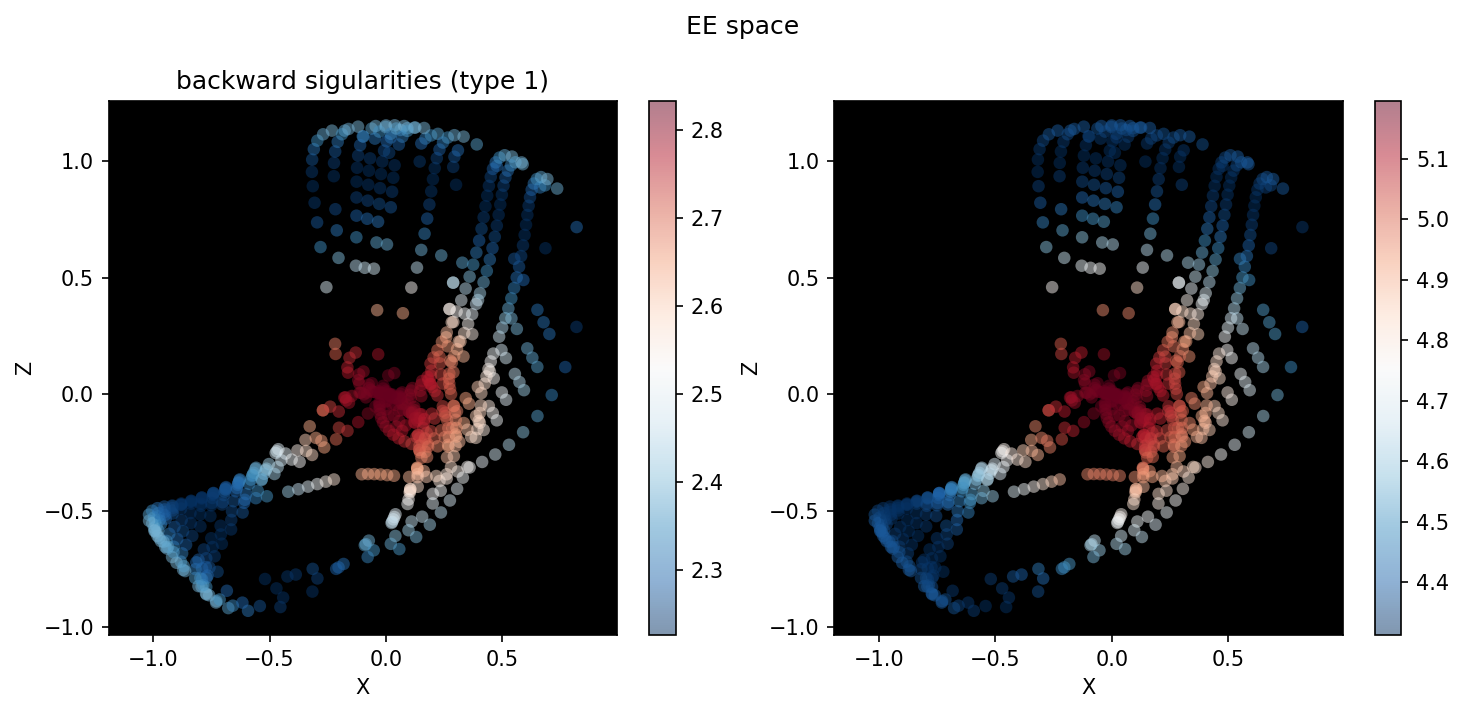

In [ ]:
fig = plt.figure(figsize=(10, 4.8), dpi=150) #6.4 4.8
ax = fig.add_subplot(1, 2, 1)
ax.set_facecolor((0., 0., 0.))
# plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox, cmap='Spectral_r', norm='log', linewidth=0, alpha=0.3)
# plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox, cmap='coolwarm', norm='log', linewidth=0, alpha=0.3)
plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox, cmap='RdBu_r', norm='linear', linewidth=0,  alpha=0.5)
plt.suptitle("EE space")
plt.title("backward sigularities (type 1)")
plt.xlabel("X")
plt.ylabel("Z")
plt.axis('equal')
plt.tight_layout()
plt.colorbar()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor((0., 0., 0.))
plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=prox, cmap='RdBu_r', norm='linear', linewidth=0,  alpha=0.5)
# plt.title("forward sigularities (type 2)")
plt.xlabel("X")
plt.ylabel("Z")
plt.axis('equal')
plt.tight_layout()
plt.colorbar()

plt.show()

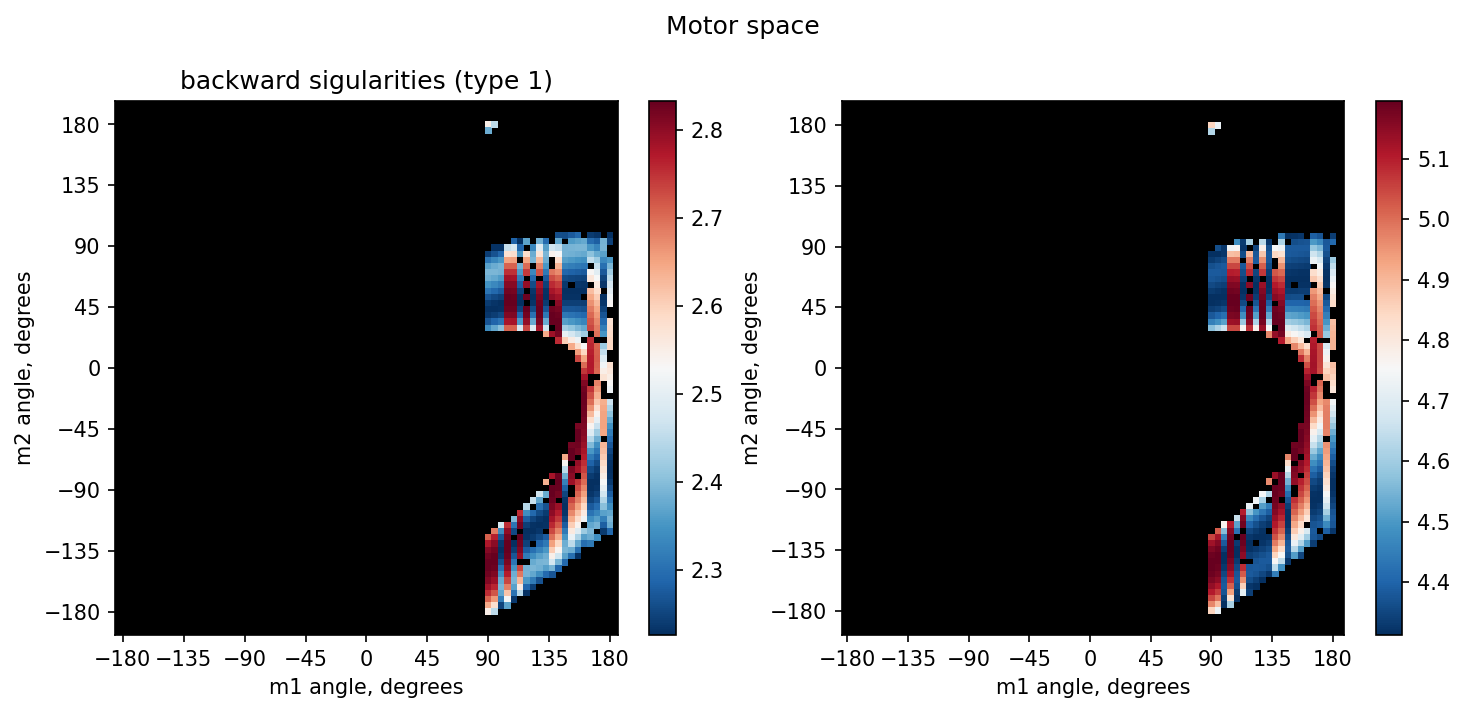

In [ ]:
fig = plt.figure(figsize=(10, 4.8), dpi=150)
ax = fig.add_subplot(1, 2, 1)
ax.set_facecolor((0., 0., 0.))
fig.canvas.draw()
sty = abs(q_act[0, 1]-q_act[1, 1])/np.pi*180
msize = ((ax.get_window_extent().width * 72./fig.dpi / 360*sty) ** 2)

# msize = ((sty) ** 2)

# plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='Spectral_r', norm='log', linewidth=0, s=18)
# plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='BrBG', norm='log', linewidth=0, s=18) #'coolwarm'
plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='RdBu_r', norm='linear', linewidth=0, marker='s', s=msize) # marker='s' s=18
# plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='jet', norm='log', linewidth=0, s=18)

# vscale = 5#10
# plt.quiver(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, 
#            rsvecs[:, 0]*vscale, rsvecs[:, 1]*vscale, 
#            color=['r'], angles='xy', scale_units='xy', scale=1)
plt.suptitle("Motor space")
plt.title("backward sigularities (type 1)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")
plt.axis('equal')
plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))
plt.xlim([-180,180])
plt.ylim([-180,180])
# ax.set_aspect(1)
plt.tight_layout()
plt.colorbar()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor((0., 0., 0.))
plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=prox, cmap='RdBu_r', norm='linear', linewidth=0, marker='s', s=msize)
# plt.title("forward sigularities (type 2)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")
plt.axis('equal')
plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))
plt.tight_layout()
plt.colorbar()

plt.show()

In [ ]:
def line_ellipse(a, b, angle=0, div=100):
    t = np.linspace(0, 2*np.pi, div)
    Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
    rot = np.array([[np.cos(angle) , -np.sin(angle)],
                    [np.sin(angle) , np.cos(angle)]])
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(rot,Ell[:,i])
    return Ell_rot

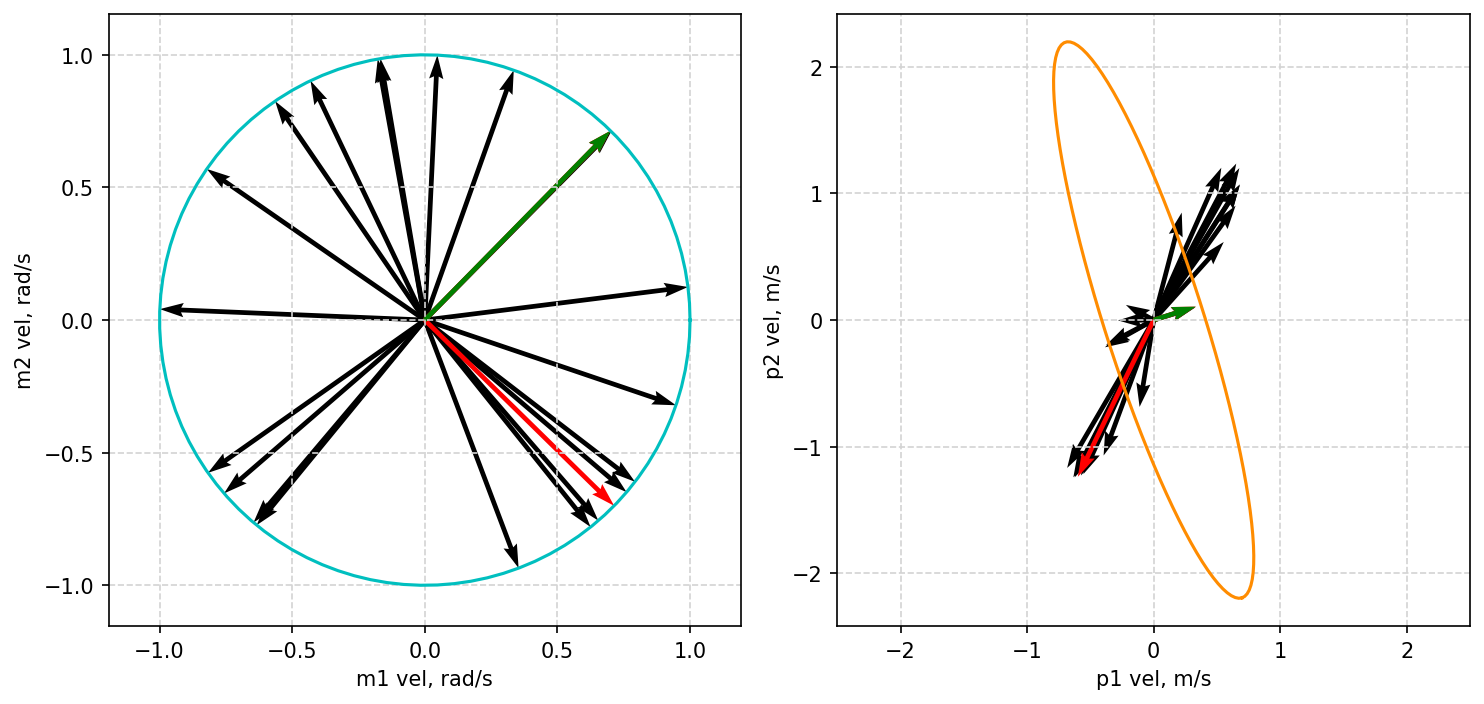

In [ ]:
# СДЕЛАТЬ НОРМ МЕХАНИЗМ 5 БАР КАК У ДИСНЕЯ ИЛИ В КНИЖКЕ. Нарисовать норм эллипсоид для якобиана, сравнить с сингвекторами

ind = 0
Jcl = jacs[ind]
U, S, Vh = svds[ind]

angs = np.random.uniform(-np.pi, np.pi, 20)

vecs = np.empty((len(angs), 2))
for i, a in enumerate(angs):
    v = np.asarray([np.cos(a), np.sin(a)])
    vecs[i,:] = v  
    
q_ell = line_ellipse(1,1)  

fig = plt.figure(figsize=(10, 4.8), dpi=150)
ax = fig.add_subplot(1, 2, 1)
plt.plot(q_ell[0,:], q_ell[1,:],'c')
vscale = 1
plt.quiver(np.zeros(len(angs)), np.zeros(len(angs)), vecs[:, 0]*vscale, vecs[:, 1]*vscale, 
           color=['k'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(2), np.zeros(2), Vh.T[0, :]*vscale, Vh.T[1, :]*vscale, 
           color=['r'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(1), np.zeros(1), rsvecs[ind, 0]*vscale, rsvecs[ind, 1]*vscale, 
           color=['g'], angles='xy', scale_units='xy', scale=1)
# plt.suptitle("Motor space")
# plt.title("backward sigularities (type 1)")
plt.grid(color='lightgray',linestyle='--')
plt.xlabel("m1 vel, rad/s")
plt.ylabel("m2 vel, rad/s")
plt.axis('equal')
plt.tight_layout()

Us = U*S
# Us = np.empty((2,2))
# Us[:,0] = Jcl@Vh.T[:,0] 
# Us[:,1] = Jcl@Vh.T[:,1]
# Us[:,0] = S[0]*Vh[0,:] # aligned with qvecs
# Us[:,1] = S[1]*Vh[1,:]

vecs2 = np.empty((len(angs), 2))
for i, qa in enumerate(vecs):
    vecs2[i] = Jcl @ qa

ee_ell = line_ellipse(S[0], S[1], np.arctan2(U[1,1],U[0,1])-np.pi/2)

ax = fig.add_subplot(1, 2, 2)
plt.plot(ee_ell[0,:], ee_ell[1,:],'darkorange')
vscale = 1
plt.quiver(np.zeros(len(angs)), np.zeros(len(angs)), vecs2[:, 0]*vscale, vecs2[:, 1]*vscale, 
           color=['k'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(2), np.zeros(2), Us[0, :]*vscale, Us[1, :]*vscale, 
           color=['r'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(1), np.zeros(1), (Jcl@rsvecs[ind, :])[0]*vscale, (Jcl@rsvecs[ind, :])[1]*vscale, 
           color=['g'], angles='xy', scale_units='xy', scale=1)
# plt.suptitle("Motor space")
# plt.title("backward sigularities (type 1)")
plt.grid(color='lightgray',linestyle='--')
plt.xlabel("p1 vel, m/s")
plt.ylabel("p2 vel, m/s")
plt.axis('equal')
plt.tight_layout()

plt.show()

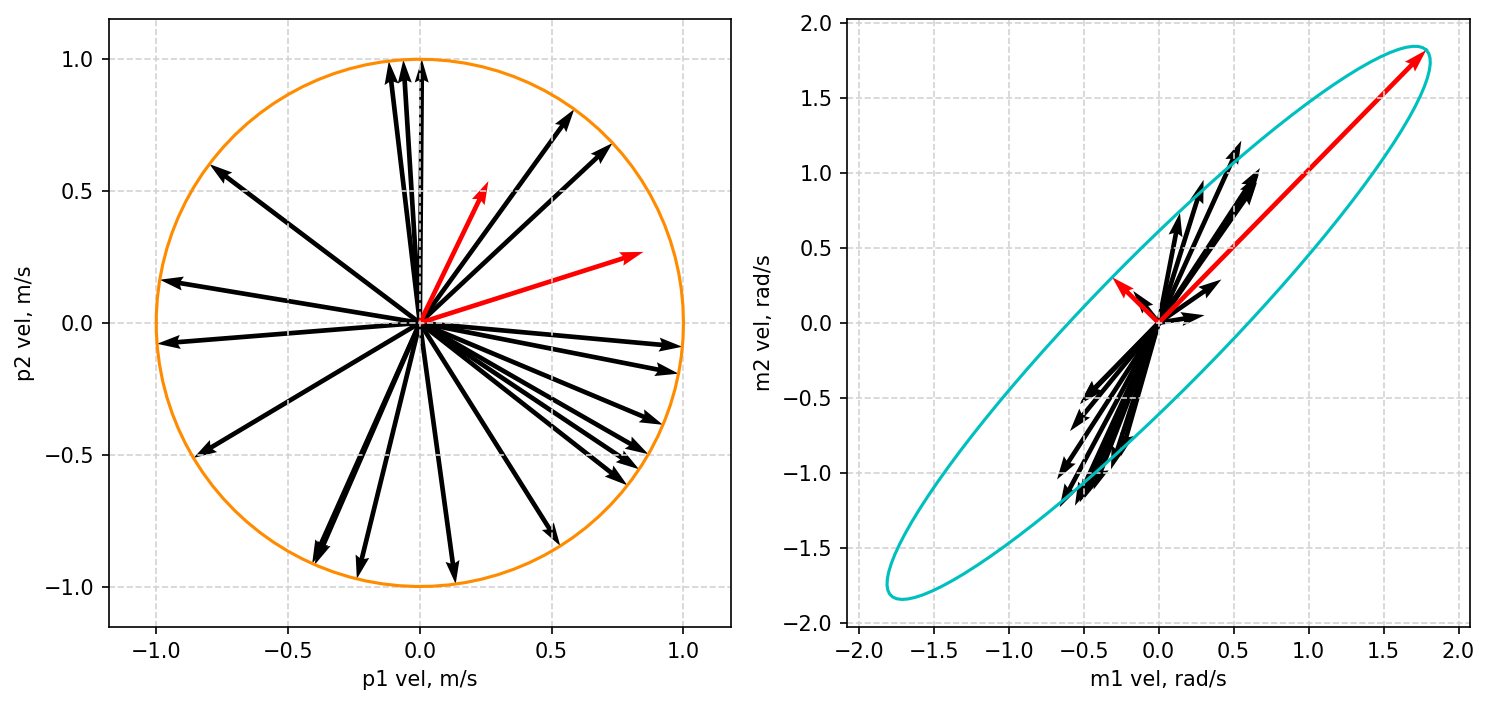

In [ ]:
Jclinv = np.linalg.pinv(Jcl)
# TODO take pinv from orig jac, not cut
U, S, Vh = svds_inv[ind]

angs = np.random.uniform(-np.pi, np.pi, 20)

vecs = np.empty((len(angs), 2))
for i, a in enumerate(angs):
    v = np.asarray([np.cos(a), np.sin(a)])
    vecs[i,:] = v  
    
ee_ell = line_ellipse(1,1)  

fig = plt.figure(figsize=(10, 4.8), dpi=150)
ax = fig.add_subplot(1, 2, 1)
plt.plot(ee_ell[0,:], ee_ell[1,:],'darkorange')
vscale = 1
plt.quiver(np.zeros(len(angs)), np.zeros(len(angs)), vecs[:, 0]*vscale, vecs[:, 1]*vscale, 
           color=['k'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(2), np.zeros(2), Vh.T[0, :]*vscale, Vh.T[1, :]*vscale, 
           color=['r'], angles='xy', scale_units='xy', scale=1)
# plt.suptitle("Motor space")
# plt.title("backward sigularities (type 1)")
plt.grid(color='lightgray',linestyle='--')
plt.xlabel("p1 vel, m/s")
plt.ylabel("p2 vel, m/s")
plt.axis('equal')
plt.tight_layout()

Us = U*S
# Us = np.empty((2,2))
# Us[:,0] = Jclinv@Vh.T[:,0] 
# Us[:,1] = Jclinv@Vh.T[:,1]
# Us[:,0] = S[0]*Vh[0,:] # aligned with qvecs
# Us[:,1] = S[1]*Vh[1,:]

vecs2 = np.empty((len(angs), 2))
for i, qa in enumerate(vecs):
    vecs2[i] = Jcl @ qa

q_ell = line_ellipse(S[0], S[1], np.arctan2(U[1,1],U[0,1])-np.pi/2)

ax = fig.add_subplot(1, 2, 2)
plt.plot(q_ell[0,:], q_ell[1,:],'c')
vscale = 1
plt.quiver(np.zeros(len(angs)), np.zeros(len(angs)), vecs2[:, 0]*vscale, vecs2[:, 1]*vscale, 
           color=['k'], angles='xy', scale_units='xy', scale=1)
plt.quiver(np.zeros(2), np.zeros(2), Us[0, :]*vscale, Us[1, :]*vscale, 
           color=['r'], angles='xy', scale_units='xy', scale=1)
# plt.suptitle("Motor space")
# plt.title("backward sigularities (type 1)")
plt.grid(color='lightgray',linestyle='--')
plt.xlabel("m1 vel, rad/s")
plt.ylabel("m2 vel, rad/s")
plt.axis('equal')
plt.tight_layout()

plt.show()